# Imports and Functions

In [1]:
import nltk
#nltk.download('punkt') # one time execution
from nltk.corpus import stopwords
from nltk import word_tokenize
import unicodedata
import re
import pandas as pd
from time import time

import visuals as vs 

%matplotlib inline



In [2]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('portuguese'))

def strip_accents(text):

    text = unicodedata.normalize('NFD', str(text))\
           .encode('ascii', 'ignore')\
           .decode("utf-8")

    return str(text)

STOPWORDS = [strip_accents(w) for w in STOPWORDS]

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = strip_accents(text) # remove accents
    text = text.replace('\n', ' ')
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

# Load Data

In [3]:
df_data = pd.read_csv('../data/data_feat.csv')
df_data.head()

,SUBJECT,AUTHOR,TEXT,TEXT_CLEAN,NUM_STOPWORDS,NUM_PUNCTUATIONS,NUM_WORDS_UPPER,NUM_CHARS,NUM_WORDS,AVG_WORD
0,ASSUNTOS VARIADOS,LUIZ FLAVIO SAPORI,19/03/2009\nFATO CORRIQUEIRO\nO fato mais impo...,19 03 2009 fato corriqueiro fato importante se...,67,29,5,1375,199,5.787129
1,ASSUNTOS VARIADOS,LUIZ FLAVIO SAPORI,06/07/2009\nPOLÍTICA DE ESTADO\nUm problema cr...,06 07 2009 politica estado problema cronico po...,75,29,11,1342,207,5.449275
2,ASSUNTOS VARIADOS,LUIZ FLAVIO SAPORI,12/07/2009\nTOQUE DE RECOLHER\nProcurado para ...,12 07 2009 toque recolher procurado suspender ...,95,46,11,1587,257,5.180392
3,ASSUNTOS VARIADOS,LUIZ FLAVIO SAPORI,23/03/2009\nCRISE SOCIOEDUCATIVA\nOcorreram du...,23 03 2009 crise socioeducativa ocorreram duas...,55,26,6,1141,167,5.761905
4,ASSUNTOS VARIADOS,LUIZ FLAVIO SAPORI,24/12/2008\nESTATÍSTICAS CRIMINAIS CONFIÁVEIS\...,24 12 2008 estatisticas criminais confiaveis b...,133,43,17,2309,366,5.246612


In [4]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3003 entries, 0 to 3002
Data columns (total 10 columns):
SUBJECT             3003 non-null object
AUTHOR              3003 non-null object
TEXT                3003 non-null object
TEXT_CLEAN          3003 non-null object
NUM_STOPWORDS       3003 non-null int64
NUM_PUNCTUATIONS    3003 non-null int64
NUM_WORDS_UPPER     3003 non-null int64
NUM_CHARS           3003 non-null int64
NUM_WORDS           3003 non-null int64
AVG_WORD            3003 non-null float64
dtypes: float64(1), int64(5), object(4)
memory usage: 234.7+ KB


# Prep Data

In [5]:
df_data['SUBJECT'] = df_data['SUBJECT'].astype('category')
df_data['AUTHOR'] = df_data['AUTHOR'].astype('category')

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_data['TEXT_CLEAN'], df_data['AUTHOR'],
                                                    test_size=0.2, stratify=df_data['AUTHOR'], random_state=42)

In [7]:
print(f'train size {len(X_train)}')
print(f'test size {len(X_test)}')

train size 2402
test size 601


# Baseline

In [8]:
# Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import f1_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end-start
        
    # Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end-start
            
    # Compute accuracy on the training samples 
    results['acc_train'] = accuracy_score(y_train,predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    # Compute F-score on the training samples using fbeta_score()
    results['f1_train'] = f1_score(y_train,predictions_train,average='micro')
        
    # Compute F-score on the test set which is y_test
    results['f1_test'] = f1_score(y_test,predictions_test,average='micro')
       
    # Success
    if learner.__class__.__name__ == 'Pipeline':
        print("{} trained on {} samples.".format(type(learner.named_steps['clf']).__name__, sample_size)) 
    else:
        print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

In [36]:
# Import the three supervised learning models from sklearn
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neural_network import MLPClassifier
#from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer(min_df=3,  max_features=None, analyzer='word',tokenizer=word_tokenize,
                    ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1)

# Initialize the three models
clf_A = Pipeline([('vect', tfidf_vec),
                  ('clf', LogisticRegression(solver='lbfgs', random_state=42, n_jobs=-1))
                 ])

clf_B = Pipeline([('vect', tfidf_vec), 
                  ('clf', SGDClassifier(random_state=42, n_jobs=-1))
                 ])

clf_C = Pipeline([('vect', tfidf_vec), 
                  ('clf', MLPClassifier(learning_rate='adaptive', early_stopping=True, random_state=42))
                 ])

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = int(len(X_train)/100)
samples_10 = int(len(X_train)/10)
samples_100 = int(len(X_train))

In [11]:
# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    if clf.__class__.__name__ == 'Pipeline':
        clf_name = type(clf.named_steps['clf']).__name__
    else:
        clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

LogisticRegression trained on 24 samples.
LogisticRegression trained on 240 samples.
LogisticRegression trained on 2402 samples.


/Users/thiagovieira/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier trained on 24 samples.


/Users/thiagovieira/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier trained on 240 samples.


/Users/thiagovieira/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier trained on 2402 samples.
MLPClassifier trained on 24 samples.
MLPClassifier trained on 240 samples.
MLPClassifier trained on 2402 samples.


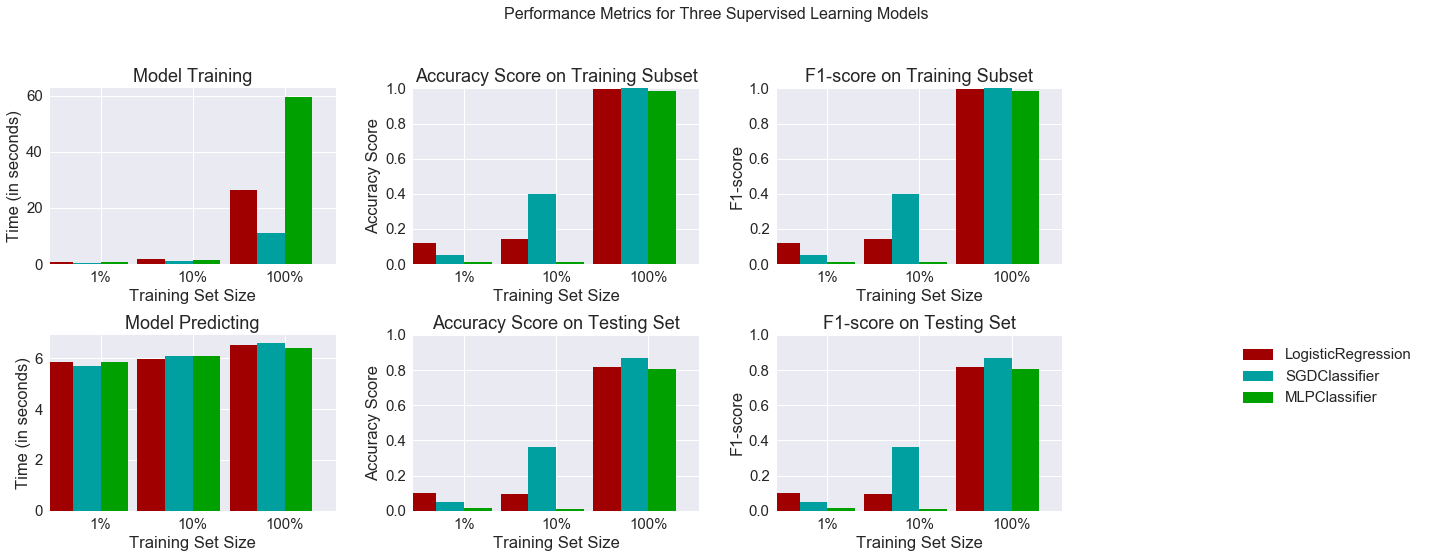

In [12]:
# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, None, None)

In [19]:
print(f"LogisticRegression: {results['LogisticRegression'][2]['f1_test']}")
print(f"SGDClassifier: {results['SGDClassifier'][2]['f1_test']}")
print(f"MLPClassifier: {results['MLPClassifier'][2]['f1_test']}")

LogisticRegression: 0.8153078202995009
SGDClassifier: 0.8718801996672213
MLPClassifier: 0.8086522462562397


## GridSearch

In [39]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer
from sklearn.linear_model import SGDClassifier


# Initialize the classifier
pipe = Pipeline([('vect', tfidf_vec), 
                ('clf', SGDClassifier())
               ])

# the parameters list.
parameters = {
    'clf__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2], # learning rate
    'clf__max_iter': [1000], # number of epochs
    'clf__loss': ['log'], # logistic regression,
    'clf__penalty': ['l2'],
    'clf__early_stopping': [True],
    'clf__learning_rate': ['adaptive', 'optimal'],
    'clf__n_jobs': [-1]
}

# Make an f1_score scoring object using make_scorer()
scorer = make_scorer(f1_score, average='micro')

In [38]:
# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(pipe, parameters,scoring=scorer, cv=5)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
# Get the estimator
best_clf = grid_fit.best_estimator_
print(best_clf)

best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Optimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F1-score on the testing data: {:.4f}".format(f1_score(y_test, best_predictions)))